# Homework - Regression (advanced)

***Agata Makarewicz***

*Week 14*

### 0. Introduction

Task: regression - predicting count of bikes lent by rental company

Dataset contains information collected by bike rental service. Our target is bike sharing count aggregated on hourly basis. Total number of records: 17379 hours (2 years of rental services). 

https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

In [1]:
# loading packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split, TimeSeriesSplit, PredefinedSplit, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error # if squared=False - RMSE
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import HuberRegressor

import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.max_columns = None

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [2]:
data = pd.read_csv('hour.csv')

### I. EDA

Attribute information:
* instant: record index
* dteday : date of record
* hr : hour (0 to 23) of record
* season : season (1:springer, 2:summer, 3:fall, 4:winter)
* yr : year (0: 2011, 1:2012)
* mnth : month (1 to 12)
* holiday : whether day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
* weekday : day of the week
* workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit : weather situation in the current timeframe
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp : Normalized temperature in Celsius. The values are divided to 41 (max)
* atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users (target 1)
* registered: count of registered users (target 2)
* cnt: count of total rental bikes including both casual and registered (target total)

In [3]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


We can see that we have no missing values in our data and that almost all of our variables are numerical. One is of type `object` but we can expect it's actually a datetime feature, given the next few variables (`yr`, `month`, `hr` etc.). Also, given the presence of these features, it's possible that some of them are in fact categorical, just ordinally encoded.

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


As we can see, `instant` variable is just an index, which is not really useful for us, so we will drop it later on. We can also observed that our target distribution is really skewed.

#### Correlated features

<AxesSubplot:>

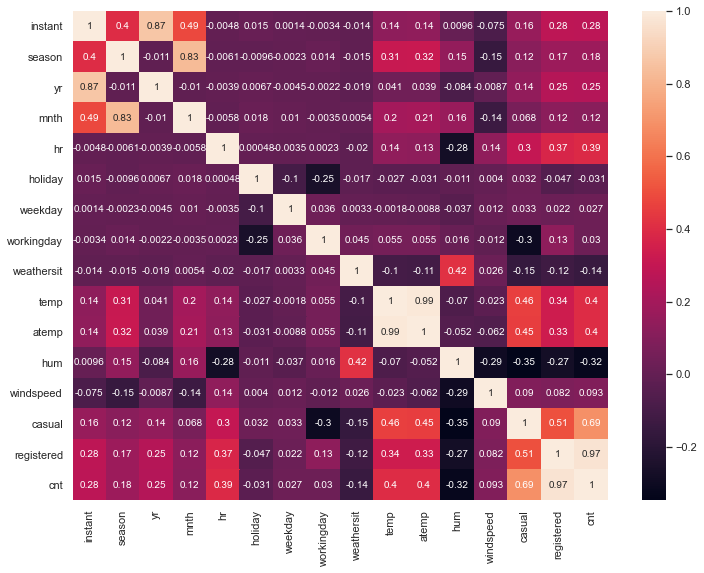

In [6]:
corr = data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(corr, annot=True)

Obviously, our three target variables (`casual`, `registered`, `cnt`) are strongly correlated, especially the last two. There is also very strong correlation between `temp` and `atemp` features, which is also expected behavior given that temperature and feeling temperature are very similar and dependent from one another. Given value almost equal to 1, one of them should be dropped. Another distinctive value can be spotted in the upper left corner - between `instant` and `yr` variables. This value is also easily explainable - `instant` is practically and index of our data, and the data is chronological. Also `season` and `month` are strongly correlated, which is also quite obvious.

#### Relationships between data

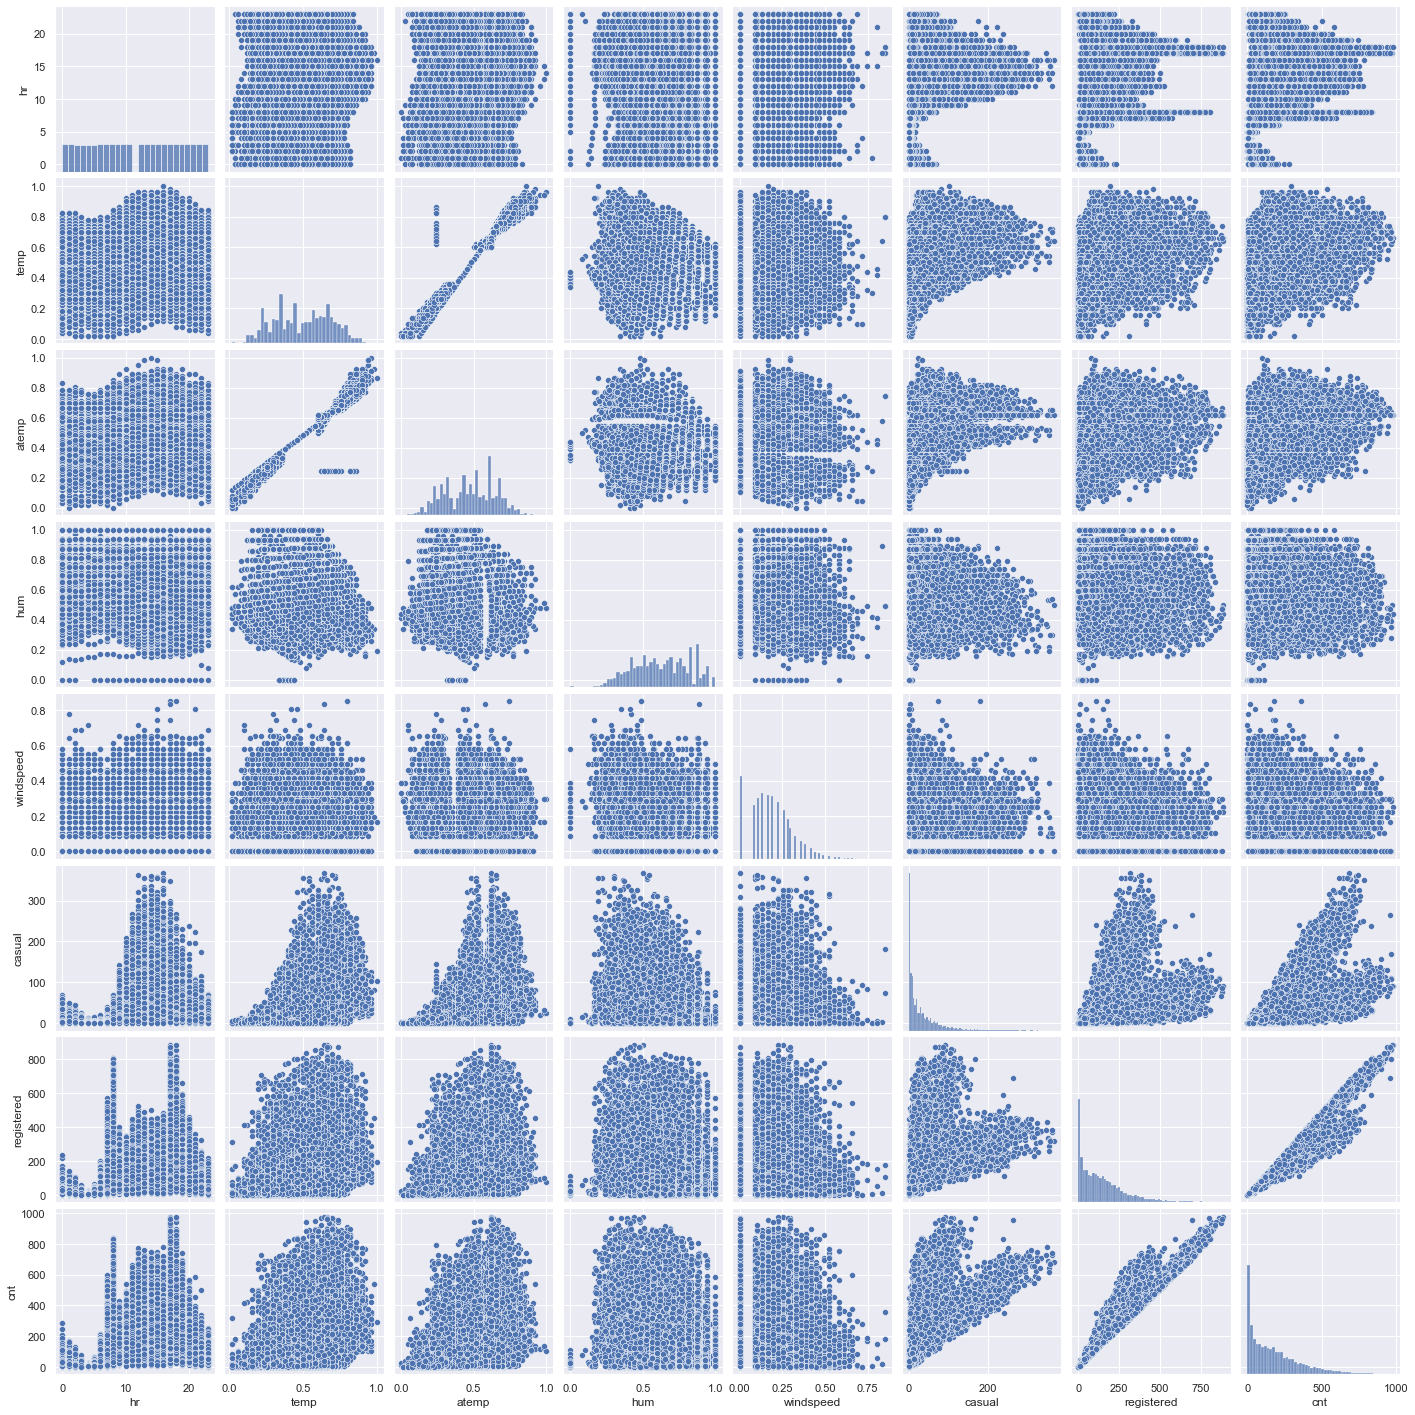

In [7]:
sns.pairplot(data.drop(['instant','mnth','yr','season','holiday','weekday','workingday','weathersit'], axis=1))

We can indeed see those strong correlations observed before, but in case of `temp` and `atemp` we can spot some outliers, for which temperature is significantly higher than the feeling one. Also `hour` and target variables have interesting relation - we can see that most bikes are rented around 8 AM (so the time people go to work/school) and then in the afternoon (while coming back home); in case of casual users there's a peak around 3 PM. There is also a lot of records without windspeed measured.

We can also observe that main weather indicators - `temp`, `humidity` and `windspeed` influence maily casual rental count rate, which are more spontaneous and dependent from the weather. The higher the temperature, lower humidity and windspeed, the higher the rental count rate. Those relations are also present in case of registered and total target, but less distinct. 

Let's now identify those spotted outliers.

In [8]:
data.query('temp > 0.5 and atemp < 0.4')

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
14131,14132,2012-08-17,3,1,8,0,0,5,1,1,0.68,0.2424,0.57,0.1642,21,67,88
14132,14133,2012-08-17,3,1,8,1,0,5,1,1,0.66,0.2424,0.65,0.1045,16,38,54
14133,14134,2012-08-17,3,1,8,2,0,5,1,1,0.66,0.2424,0.61,0.1343,4,15,19
14134,14135,2012-08-17,3,1,8,3,0,5,1,1,0.64,0.2424,0.65,0.1045,0,6,6
14135,14136,2012-08-17,3,1,8,4,0,5,1,1,0.64,0.2424,0.73,0.1642,0,9,9
14136,14137,2012-08-17,3,1,8,5,0,5,1,1,0.64,0.2424,0.73,0.1045,2,34,36
14137,14138,2012-08-17,3,1,8,6,0,5,1,1,0.62,0.2424,0.78,0.1343,6,151,157
14138,14139,2012-08-17,3,1,8,7,0,5,1,1,0.64,0.2424,0.73,0.1045,11,368,379
14139,14140,2012-08-17,3,1,8,8,0,5,1,1,0.68,0.2424,0.65,0.1343,43,625,668
14140,14141,2012-08-17,3,1,8,9,0,5,1,1,0.70,0.2424,0.58,0.1045,58,320,378


We can see that those are the records from the same day, and the only odd thing about them is `atemp` value.
However, given the features' high correlation, one of them will be dropped, for instance `atemp`, which will solve the problem, as in relation to other variables those observations don't stand out.

Let's now analyze categorical/binary features.

In [9]:
def plot_cat_vs_target(feature):
    fig, ax = plt.subplots(1,3, figsize=(27,6))
    sns.barplot(data[feature], data.casual, ax=ax[0]).set_title('Casual vs '+feature, size=14)
    sns.barplot(data[feature], data.registered, ax=ax[1]).set_title('Registered vs '+feature, size=14)
    sns.barplot(data[feature], data.cnt, ax=ax[2]).set_title('Cnt vs '+feature, size=14)

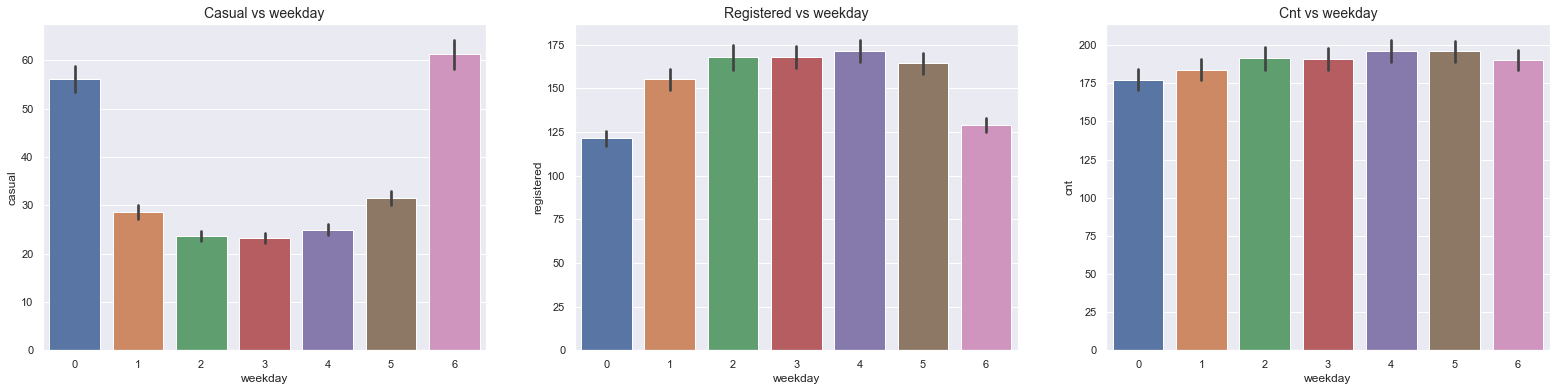

In [10]:
plot_cat_vs_target('weekday')

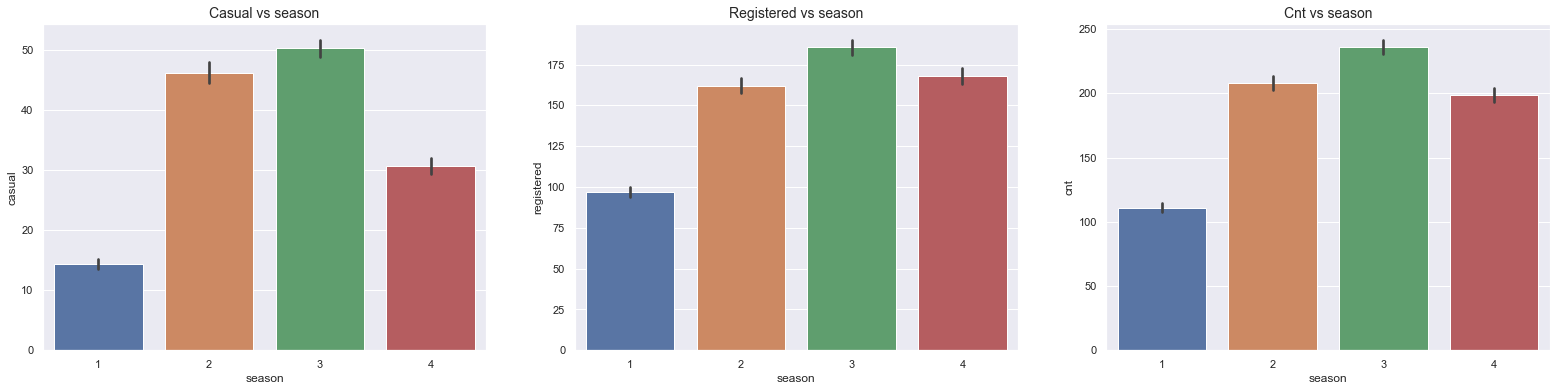

In [11]:
plot_cat_vs_target('season')

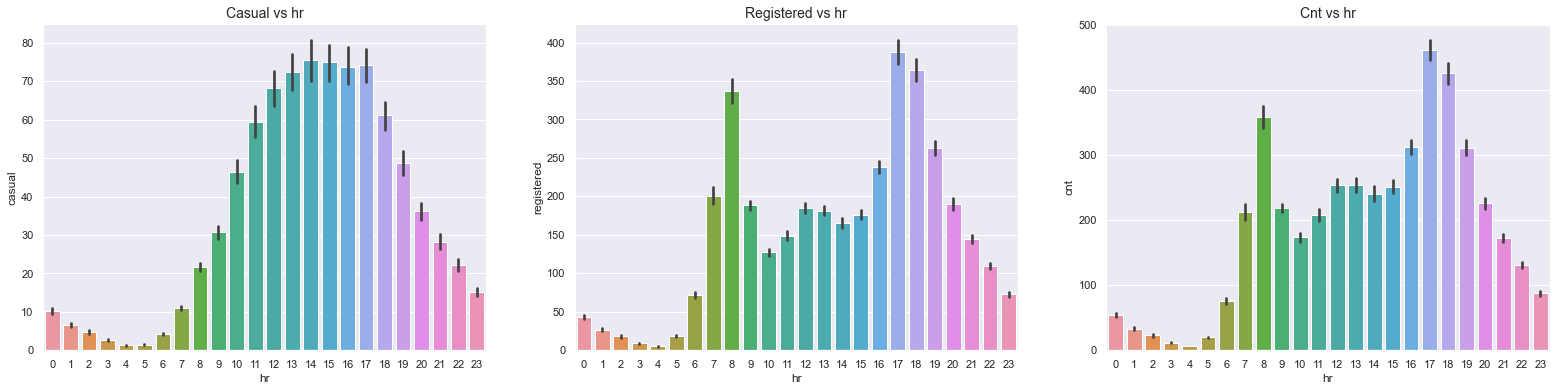

In [12]:
plot_cat_vs_target('hr')

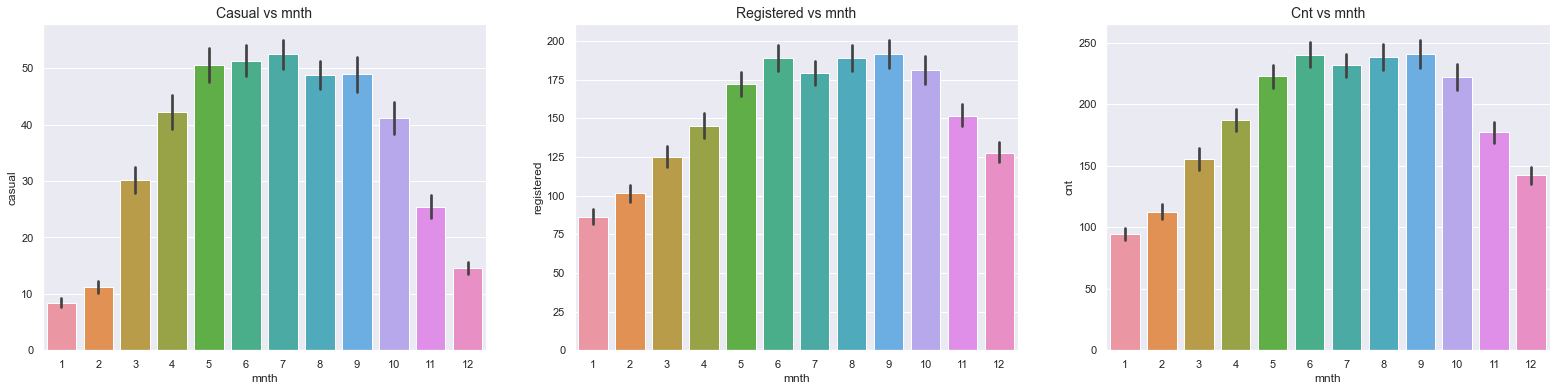

In [13]:
plot_cat_vs_target('mnth')

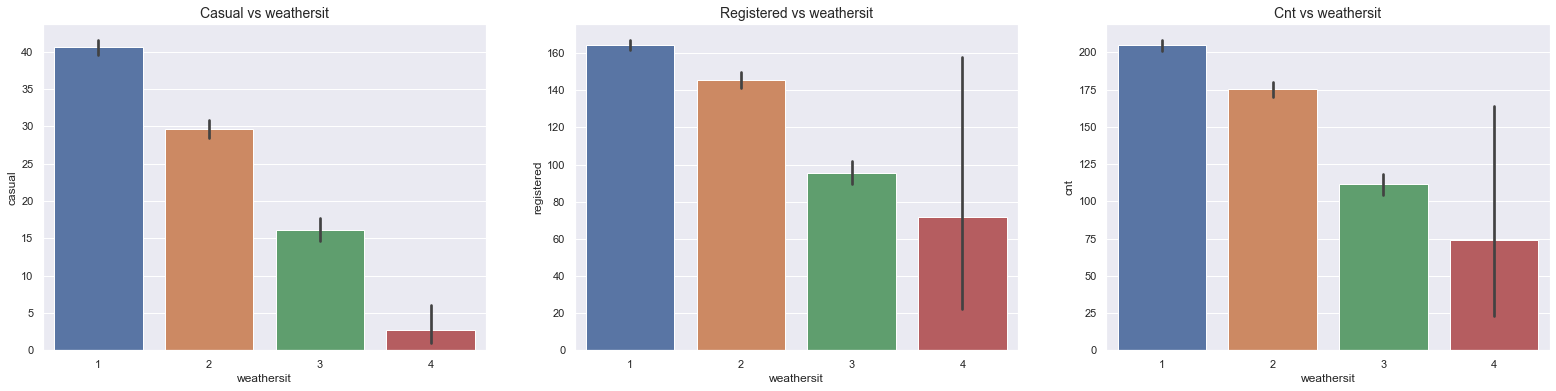

In [14]:
plot_cat_vs_target('weathersit')

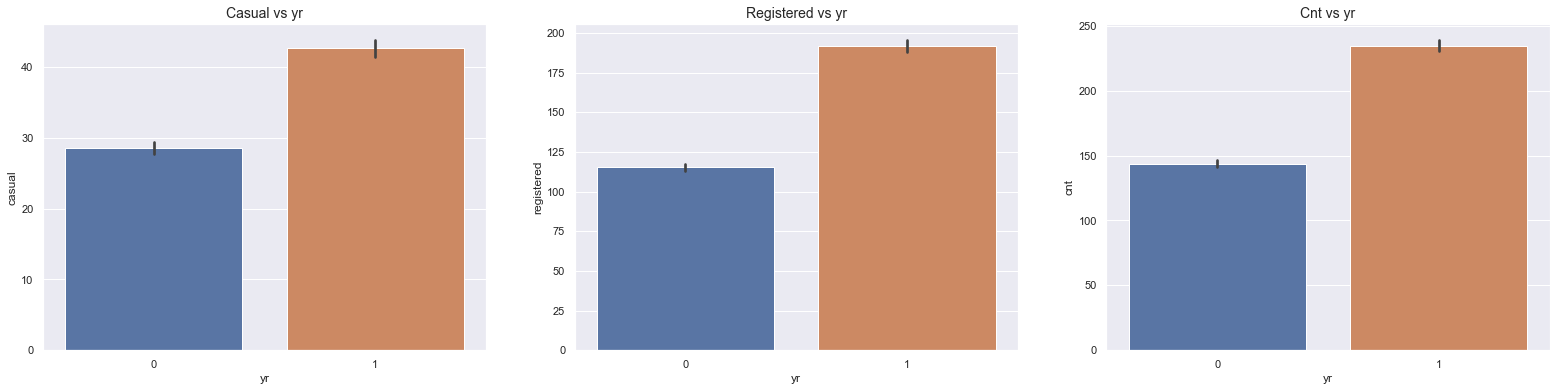

In [15]:
plot_cat_vs_target('yr')

We can observe some expected tendencies, such as definitely more rentals in spring-summer-autumn months. However, `season` variable should be rather interpreted as quartile, as for instance spring should contain 3,4, and 5 month, not first three. Also, there's a significant difference in case of `weekday` - most casual users rent bikes during the weekend, while registered ones - on workingdays. As for the weather, there's also no surprise in the results - the better, the more rentals.
We can also observe there's definitely more rentals in the second available year (2012). Still, the `hour` seems to have the biggest impact on all of our targets.

#### Target analysis

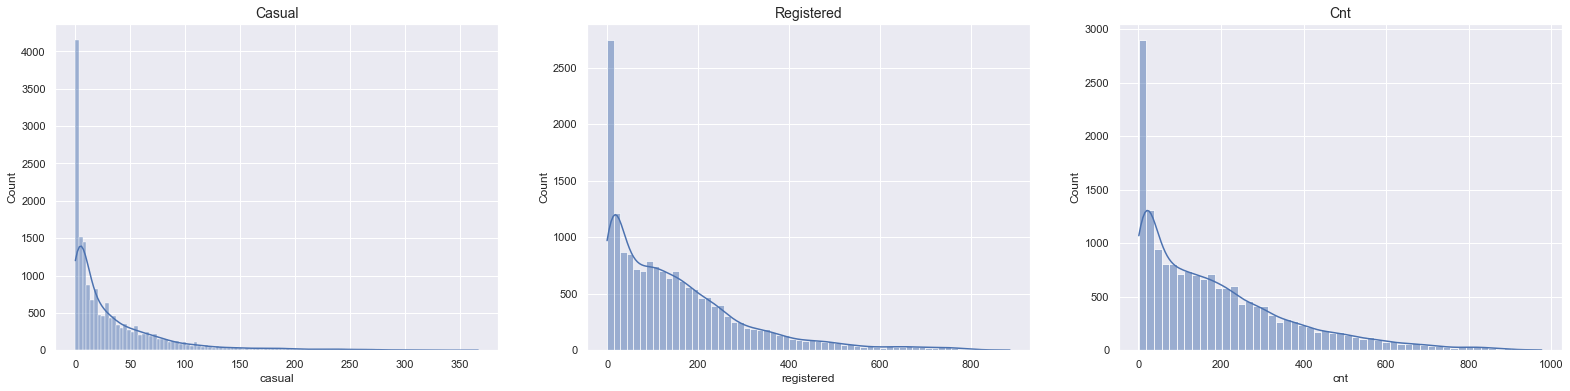

In [16]:
fig, ax = plt.subplots(1,3, figsize=(27,6))
sns.histplot(data.casual, kde=True, ax=ax[0]).set_title('Casual', size=14)
sns.histplot(data.registered, kde=True, ax=ax[1]).set_title('Registered', size=14)
sns.histplot(data.cnt, kde=True, ax=ax[2]).set_title('Cnt', size=14);

We can observe that our target distribution is really skewed, which can cause poorer predictions. Let's check how it will look like after log transformation.

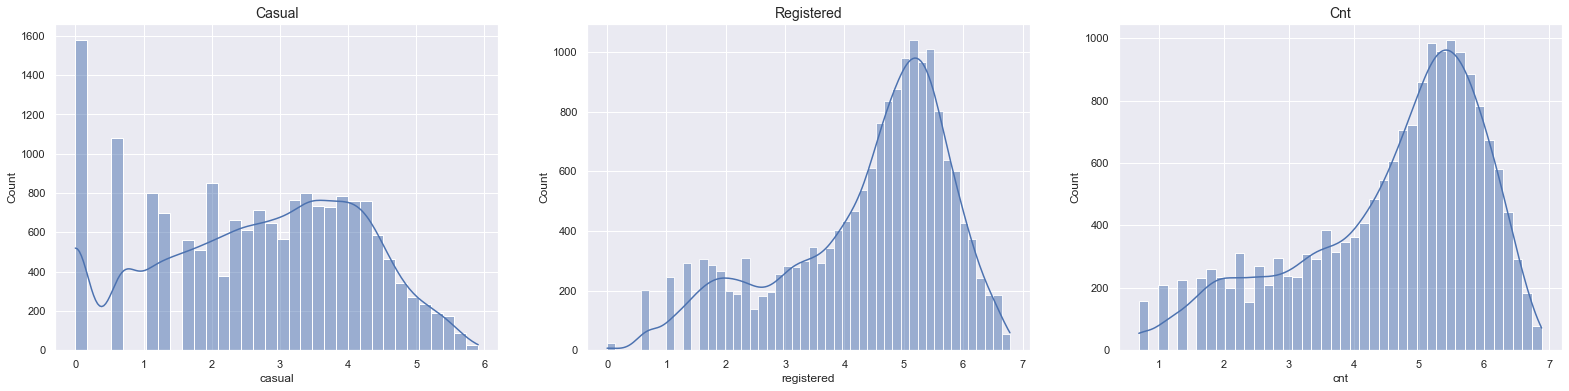

In [17]:
fig, ax = plt.subplots(1,3, figsize=(27,6))
sns.histplot(np.log1p(data.casual), kde=True, ax=ax[0]).set_title('Casual', size=14)
sns.histplot(np.log1p(data.registered), kde=True, ax=ax[1]).set_title('Registered', size=14)
sns.histplot(np.log1p(data.cnt), kde=True, ax=ax[2]).set_title('Cnt', size=14);

The distributions look better, so we will probably use this transform to better our models' performance.

### II. Preprocessing & feature engineering

Given the nature of our data (time series), we get rid of `instant` variable and set `dteday` connected with `hour` as index, and in addition, extract `day` to another column. This way all the information about time we can get from our variables. We also drop one of temperature variables, as we stated before, due to high correlation which indicates they're basically the same indicator.

In [18]:
data = data.drop(['instant','atemp'], axis=1)

In [19]:
def get_hour(x):
    if len(str(x))==2: return str(x)
    else: return '0' + str(x)
    
data['datetime'] = data[['dteday','hr']].apply(lambda x: x['dteday'] + " " + get_hour(x['hr']) + ":00", axis=1)
data['datetime'] = pd.to_datetime(data.datetime, format='%Y-%m-%d %H:%M')
data['day'] = data['datetime'].dt.day

In [20]:
data = data.drop('dteday', axis=1)
data.set_index('datetime', inplace=True)

In [21]:
data.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt,day
datetime,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,13,16,1
2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,27,32,1
2011-01-01 03:00:00,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,10,13,1
2011-01-01 04:00:00,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,1,1


As for the variables, which should be categorical, we can say they're already encoded, as they're in fact ordinal. We could create some dummy features instead, but let's leave it for later, if our model will be performing poorly despite other improvements.

Another thing, true numerical data is already normalized, so there's no need to do that again.

We will build our models for each year of rentals separately, so we need to split our data due to `yr` variable value.

In [22]:
data_0 = data.query('yr==0') # year 2011
data_1 = data.query('yr==1') # year 2012

In [23]:
data_0_x = data_0.drop(['cnt', 'casual', 'registered'], axis=1)

target_0_cnt = data_0['cnt']
target_0_cas = data_0['casual']
target_0_reg = data_0['registered']

In [24]:
data_1_x = data_1.drop(['cnt', 'casual', 'registered'], axis=1)

target_1_cnt = data_1['cnt']
target_1_cas = data_1['casual']
target_1_reg = data_1['registered']

As for creation of other features, we will use *sklearn.preprocessing.PolynomialFeatures()* to generate polynomial and interaction features of desired degree. Additionaly, we will perform log transform of our target to check if it improves the prediction quality.

### III. Regression algorithms

In [25]:
# helper functions
def evaluate(regressor, X_train_a, y_train_a, X_train_b, y_train_b, X_test_a, y_test_a, X_test_b, y_test_b):
    regressor.fit(X_train_a, y_train_a)
    y_pred_a = regressor.predict(X_test_a)
    print('2011: ', regressor.best_params_, ' score: ', abs(regressor.best_score_))
    regressor.fit(X_train_b, y_train_b)
    y_pred_b = regressor.predict(X_test_b)
    print('2012: ', regressor.best_params_, ' score: ', abs(regressor.best_score_))

    return pd.DataFrame({
        'MAE': [mean_absolute_error(y_test_a, y_pred_a), mean_absolute_error(y_test_b, y_pred_b)], 
        'MSE': [mean_squared_error(y_test_a, y_pred_a), mean_squared_error(y_test_b, y_pred_b)],
        'RMSE': [np.sqrt(mean_squared_error(y_test_a, y_pred_a)), np.sqrt(mean_squared_error(y_test_b, y_pred_b))],
        'R2': [r2_score(y_test_a, y_pred_a), r2_score(y_test_b, y_pred_b)],
        'Adj R2': [1 - (1-r2_score(y_test_a, y_pred_a))*(len(y_test_a)-1)/(len(y_test_a)-X_test_a.shape[1]-1),
                   1 - (1-r2_score(y_test_b, y_pred_b))*(len(y_test_b)-1)/(len(y_test_b)-X_test_b.shape[1]-1)]
    }, index=['2011','2012'])

In [26]:
# helper functions
def plot_importance(importances, colnames):
    importance = pd.DataFrame({'Weight': np.abs(importances),'Variable': colnames})
    imp = importance.sort_values(by='Weight', ascending=False)
    sns.barplot( x='Weight',y='Variable', data=imp).set_title('Feature importance', size=14)

We decide to shuffle our data despite having timeseries data, to get better independence.

In [27]:
# train/test split 
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(data_0_x, target_0_cnt)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(data_1_x, target_1_cnt)

In [28]:
# crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=123)

For each algorithm, we will create model for each year, with normal target and target after log transform. Additionaly, apart from metrics chosen for evaluation of prediction, we will print best parameters found by crossvalidation, and average score (MSE).

#### KNN 

In [39]:
param_grid = {'n_neighbors': [2,3,4,5,6], 'weights': ['uniform','distance']}

knr = GridSearchCV(KNeighborsRegressor(),
                   param_grid,
                   n_jobs=-1,
                   scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], 
                   refit='neg_mean_squared_error', 
                   cv=kfold)

In [40]:
evaluate(knr, X_train_0, y_train_0, X_train_1, y_train_1, X_test_0, y_test_0, X_test_1, y_test_1)

2011:  {'n_neighbors': 3, 'weights': 'distance'}  score:  3706.57556454826
2012:  {'n_neighbors': 3, 'weights': 'distance'}  score:  9286.282802122405


,MAE,MSE,RMSE,R2,Adj R2
2011,33.883091,2689.841879,51.863686,0.847916,0.847067
2012,53.079232,6193.693463,78.700022,0.853748,0.852940


In [41]:
evaluate(knr, X_train_0, np.log1p(y_train_0), X_train_1, np.log1p(y_train_1), X_test_0, np.log1p(y_test_0), X_test_1, np.log1p(y_test_1))

2011:  {'n_neighbors': 4, 'weights': 'distance'}  score:  0.2760044283734362
2012:  {'n_neighbors': 3, 'weights': 'distance'}  score:  0.2745865240595648


,MAE,MSE,RMSE,R2,Adj R2
2011,0.317936,0.192143,0.438342,0.897891,0.897321
2012,0.300702,0.178140,0.422067,0.908705,0.908200


#### Decision Tree 

In [42]:
param_grid = {"splitter":["best","random"],
              "max_depth" : [1,3,5,7,9,12],
              "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
              "max_features":["auto","log2","sqrt",None]}

dtr = GridSearchCV(DecisionTreeRegressor(),
                   param_grid,
                   n_jobs=-1,
                   scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], 
                   refit='neg_mean_squared_error', 
                   cv=kfold)

In [43]:
evaluate(dtr, X_train_0, y_train_0, X_train_1, y_train_1, X_test_0, y_test_0, X_test_1, y_test_1)

2011:  {'max_depth': 12, 'max_features': None, 'min_samples_leaf': 5, 'splitter': 'best'}  score:  2269.197151016578
2012:  {'max_depth': 12, 'max_features': None, 'min_samples_leaf': 3, 'splitter': 'best'}  score:  4334.103585032


,MAE,MSE,RMSE,R2,Adj R2
2011,27.288854,1958.291915,44.252592,0.889278,0.888660
2012,38.290363,3877.040461,62.265885,0.908451,0.907945


In [44]:
evaluate(dtr, X_train_0, np.log1p(y_train_0), X_train_1, np.log1p(y_train_1), X_test_0, np.log1p(y_test_0), X_test_1, np.log1p(y_test_1))

2011:  {'max_depth': 12, 'max_features': None, 'min_samples_leaf': 6, 'splitter': 'best'}  score:  0.17574939208963228
2012:  {'max_depth': 12, 'max_features': None, 'min_samples_leaf': 6, 'splitter': 'best'}  score:  0.1501579193572163


,MAE,MSE,RMSE,R2,Adj R2
2011,0.293427,0.190483,0.436443,0.898774,0.898208
2012,0.249482,0.141105,0.375639,0.927685,0.927285


#### Random Forest

In [45]:
param_grid = {'n_estimators': [25, 50, 100],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [5, 10, 15],
               'min_samples_split': [2, 5, 10]}

rfr = GridSearchCV(RandomForestRegressor(),
                   param_grid,
                   n_jobs=-1,
                   scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], 
                   refit='neg_mean_squared_error', 
                   cv=kfold)

In [46]:
evaluate(rfr, X_train_0, y_train_0, X_train_1, y_train_1, X_test_0, y_test_0, X_test_1, y_test_1)

2011:  {'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}  score:  1354.996665756039
2012:  {'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}  score:  2674.5102999643955


,MAE,MSE,RMSE,R2,Adj R2
2011,22.677502,1350.230537,36.745483,0.923658,0.923232
2012,29.517420,2313.587654,48.099768,0.945369,0.945067


In [47]:
evaluate(rfr, X_train_0, np.log1p(y_train_0), X_train_1, np.log1p(y_train_1), X_test_0, np.log1p(y_test_0), X_test_1, np.log1p(y_test_1))

2011:  {'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}  score:  0.11273908103868664
2012:  {'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 100}  score:  0.09983508283988314


,MAE,MSE,RMSE,R2,Adj R2
2011,0.227771,0.119625,0.345869,0.936429,0.936074
2012,0.198873,0.090320,0.300532,0.953712,0.953456


#### SVM 

In [36]:
param_grid = {'kernel': ['rbf'], 
              'gamma': [0.01, 0.1, 0.5],
              # 'gamma': [1e-3, 0.01, 0.1, 0.5],
              #'C': [10, 100, 1000, 10000]}
'C': [100, 1000, 10000]}

svr = GridSearchCV(SVR(),
                   param_grid,
                   n_jobs=-1,
                   scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], 
                   refit='neg_mean_squared_error', 
                   cv=kfold)

In [35]:
evaluate(svr, X_train_0, y_train_0, X_train_1, y_train_1, X_test_0, y_test_0, X_test_1, y_test_1)

2011:  {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}  score:  2035.8453777786988
2012:  {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}  score:  4772.135023539839


,MAE,MSE,RMSE,R2,Adj R2
2011,27.550951,1931.671745,43.950788,0.893671,0.893077
2012,41.371598,4244.149517,65.147137,0.906862,0.906347


In [37]:
evaluate(svr, X_train_0, np.log1p(y_train_0), X_train_1, np.log1p(y_train_1), X_test_0, np.log1p(y_test_0), X_test_1, np.log1p(y_test_1))

2011:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}  score:  0.1688197092104905
2012:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}  score:  0.1540613473584762


,MAE,MSE,RMSE,R2,Adj R2
2011,0.270229,0.153217,0.391429,0.915266,0.914793
2012,0.243698,0.126027,0.355002,0.936594,0.936244


#### AdaBoost

In [48]:
param_grid = {"base_estimator__splitter" : ["best", "random"],
              "base_estimator__max_depth" : [5,10,15],
              "base_estimator__min_samples_split":[2,5,10],
              "n_estimators" : [25, 50, 100],
              "learning_rate" : [0.001, 0.01, 0.1, 1.0]}

abr = GridSearchCV(AdaBoostRegressor(base_estimator = DecisionTreeRegressor()),
                   param_grid,
                   n_jobs=-1,
                   scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], 
                   refit='neg_mean_squared_error', 
                   cv=kfold)

In [49]:
evaluate(abr, X_train_0, y_train_0, X_train_1, y_train_1, X_test_0, y_test_0, X_test_1, y_test_1)

2011:  {'base_estimator__max_depth': 15, 'base_estimator__min_samples_split': 10, 'base_estimator__splitter': 'random', 'learning_rate': 0.1, 'n_estimators': 100}  score:  1275.11444964822
2012:  {'base_estimator__max_depth': 15, 'base_estimator__min_samples_split': 5, 'base_estimator__splitter': 'random', 'learning_rate': 0.01, 'n_estimators': 100}  score:  2476.358165281055


,MAE,MSE,RMSE,R2,Adj R2
2011,21.459492,1171.538773,34.227749,0.933761,0.933391
2012,28.266573,2059.266873,45.379146,0.951374,0.951106


In [50]:
evaluate(abr, X_train_0, np.log1p(y_train_0), X_train_1, np.log1p(y_train_1), X_test_0, np.log1p(y_test_0), X_test_1, np.log1p(y_test_1))

2011:  {'base_estimator__max_depth': 15, 'base_estimator__min_samples_split': 10, 'base_estimator__splitter': 'random', 'learning_rate': 0.1, 'n_estimators': 100}  score:  0.1099288103721879
2012:  {'base_estimator__max_depth': 15, 'base_estimator__min_samples_split': 10, 'base_estimator__splitter': 'random', 'learning_rate': 0.1, 'n_estimators': 100}  score:  0.09042470931251238


,MAE,MSE,RMSE,R2,Adj R2
2011,0.216879,0.100902,0.317650,0.946379,0.946079
2012,0.193203,0.087994,0.296637,0.954904,0.954655


#### Huber

In [59]:
param_grid = {"epsilon" : [1.2, 1.5, 2.5, 5],
              "alpha" : [0.0001, 0.001, 0.01, 1.0, 2, 5],
              "max_iter" : [50, 100, 200, 500]}

hbr = GridSearchCV(HuberRegressor(),
                   param_grid,
                   n_jobs=-1,
                   scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], 
                   refit='neg_mean_squared_error', 
                   cv=kfold)

In [60]:
evaluate(hbr, X_train_0, y_train_0, X_train_1, y_train_1, X_test_0, y_test_0, X_test_1, y_test_1)

2011:  {'alpha': 0.001, 'epsilon': 5, 'max_iter': 100}  score:  11069.217605763653
2012:  {'alpha': 0.001, 'epsilon': 5, 'max_iter': 100}  score:  28481.856828839536


,MAE,MSE,RMSE,R2,Adj R2
2011,78.893898,10917.922875,104.488865,0.382701,0.379254
2012,128.981200,28131.350300,167.724030,0.335733,0.332062


In [61]:
evaluate(hbr, X_train_0, np.log1p(y_train_0), X_train_1, np.log1p(y_train_1), X_test_0, np.log1p(y_test_0), X_test_1, np.log1p(y_test_1))

2011:  {'alpha': 2, 'epsilon': 2.5, 'max_iter': 200}  score:  0.9754483825236404
2012:  {'alpha': 5, 'epsilon': 2.5, 'max_iter': 200}  score:  1.088925728877704


,MAE,MSE,RMSE,R2,Adj R2
2011,0.780108,0.969281,0.984520,0.484905,0.482029
2012,0.845712,1.127812,1.061985,0.422006,0.418811


Due to chosen metrics, AdaBoostRegressor turned out to be the best, so we will continue to use it.

### IV. Best model

#### Feature importance

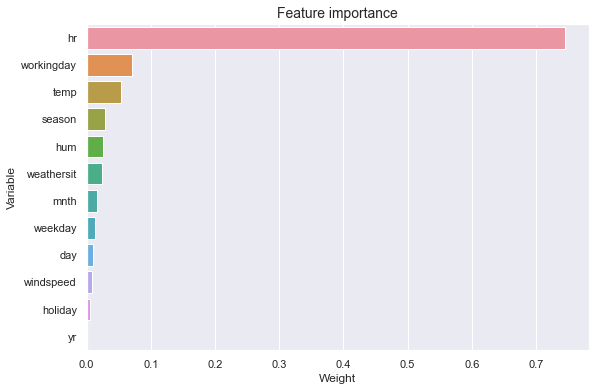

In [23]:
plot_importance(abr.best_estimator_.feature_importances_, data_0_x.columns)

From the feature importance plot we can read that definitely, as suspected in the EDA, `hour` variable is the most influential one. Next in line are `working_day` and `temp`, then `season`, `humidity` and `weathersit`, so mainly variables connected to weather, and the one surely important for `registered` count rate (`workingday`).

We decided to shuffle the data; if we didn't, then we would base the splits on the index (`datetime`) and then `hour` feature could be dropped as its value would be presented by the records order. In such situation the feature importance could surely change.

Moreover, we splitted our data due to `year` variable, and predicted count rate separately. Let's try to predict counts for the 2012 using model based on the 2011 data. For this purpose we will use already validated, selected best model.

In [20]:
abr_2011 = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth=15, min_samples_split=10, splitter='random'),
                             learning_rate = 0.1, n_estimators= 100)
abr.fit(X_train_0, y_train_0)
y_pred_2012 = abr.predict(X_test_1)
abr.fit(X_train_0, np.log1p(y_train_0))
y_pred_2012_log = abr.predict(X_test_1)
pd.DataFrame({
        'MAE': [mean_absolute_error(y_test_1, y_pred_2012), mean_absolute_error(np.log1p(y_test_1), y_pred_2012_log)], 
        'MSE': [mean_squared_error(y_test_1, y_pred_2012), mean_squared_error(np.log1p(y_test_1), y_pred_2012_log)],
        'RMSE': [np.sqrt(mean_squared_error(y_test_1, y_pred_2012)), np.sqrt(mean_squared_error(np.log1p(y_test_1), y_pred_2012_log))],
        'R2': [r2_score(y_test_1, y_pred_2012), r2_score(np.log1p(y_test_1), y_pred_2012_log)],
        'Adj R2': [1 - (1-r2_score(y_test_1, y_pred_2012))*(len(y_test_1)-1)/(len(y_test_1)-X_test_1.shape[1]-1),
                   1 - (1-r2_score(np.log1p(y_test_1), y_pred_2012_log))*(len(y_test_1)-1)/(len(y_test_1)-X_test_1.shape[1]-1)]
    }, index=['2012', '2012 log'])

,MAE,MSE,RMSE,R2,Adj R2
2012,89.561992,15901.162184,126.099810,0.639839,0.637848
2012 log,0.498288,0.321889,0.567353,0.842422,0.841551


In [69]:
print(list(y_pred_2012[0:10]))
print(list(y_test_1[0:10]))

[194.25, 6.333333333333333, 186.8, 156.6, 105.16666666666667, 14.11111111111111, 102.04761904761905, 60.625, 91.0, 346.26666666666665]
[438, 4, 233, 255, 137, 29, 164, 84, 142, 530]


We can observe that the results are far worse than before (while training on same year data), especially in case of target without log transform. It is probably due to imbalance of our target while comparing two different years (we have much more rentals in 2012 than 2011). Because of that predicted count is to small, as we can see in the sample above.

#### Polynomial features

Another modification we mentioned to use earlier are polynomial features. Let's check whether such feature engineering will improve our model's performance.

In [14]:
poly = PolynomialFeatures(2)
X_train_0_poly = pd.DataFrame(poly.fit_transform(X_train_0))
X_train_1_poly = pd.DataFrame(poly.fit_transform(X_train_1))
X_test_0_poly = pd.DataFrame(poly.fit_transform(X_test_0))
X_test_1_poly = pd.DataFrame(poly.fit_transform(X_test_1))
X_train_0_poly.shape

(6483, 91)

In [21]:
param_grid = {"base_estimator__splitter" : ["random"], "base_estimator__max_depth" : [15],
              "base_estimator__min_samples_split":[10], "n_estimators" : [100], "learning_rate" : [0.1]}

abr_poly = GridSearchCV(AdaBoostRegressor(base_estimator = DecisionTreeRegressor()),
                   param_grid,
                   n_jobs=-1,
                   scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], 
                   refit='neg_mean_squared_error', 
                   cv=kfold)

In [22]:
evaluate(abr_poly, X_train_0_poly, y_train_0, X_train_1_poly, y_train_1, X_test_0_poly, y_test_0, X_test_1_poly, y_test_1)

2011:  {'base_estimator__max_depth': 15, 'base_estimator__min_samples_split': 10, 'base_estimator__splitter': 'random', 'learning_rate': 0.1, 'n_estimators': 100}  score:  1186.7654210012781
2012:  {'base_estimator__max_depth': 15, 'base_estimator__min_samples_split': 10, 'base_estimator__splitter': 'random', 'learning_rate': 0.1, 'n_estimators': 100}  score:  2604.8436343136254


,MAE,MSE,RMSE,R2,Adj R2
2011,20.498623,1160.766826,34.070028,0.939116,0.936439
2012,26.551589,1910.373328,43.707818,0.956730,0.954848


In [23]:
evaluate(abr_poly, X_train_0_poly, np.log1p(y_train_0), X_train_1_poly, np.log1p(y_train_1), 
         X_test_0_poly, np.log1p(y_test_0), X_test_1_poly, np.log1p(y_test_1))

2011:  {'base_estimator__max_depth': 15, 'base_estimator__min_samples_split': 10, 'base_estimator__splitter': 'random', 'learning_rate': 0.1, 'n_estimators': 100}  score:  0.11332133585562838
2012:  {'base_estimator__max_depth': 15, 'base_estimator__min_samples_split': 10, 'base_estimator__splitter': 'random', 'learning_rate': 0.1, 'n_estimators': 100}  score:  0.09605738075093873


,MAE,MSE,RMSE,R2,Adj R2
2011,0.206478,0.092912,0.304815,0.950741,0.948576
2012,0.184383,0.085733,0.292802,0.958030,0.956204


With parameters optimal for our basic set of features, adding new polynomial ones of degree 2 practically doesn't change the score. We should probably perform grid search for this new set of features, but it would take a lot of time given the number of features; or perhaps increase the degree, which is also time-consuming. We have satisfactory scores without further improvements.

### V. Multitarget regression

Now instead of taking one target into account (`cnt`) we will consider 2 separate ones - `casual` and `registered`.

In [41]:
y_train_0_cas = target_0_cas[y_train_0.index.to_list()]
y_train_0_reg = target_0_reg[y_train_0.index.to_list()]

y_train_1_cas = target_1_cas[y_train_1.index.to_list()]
y_train_1_reg = target_1_reg[y_train_1.index.to_list()]

In [42]:
y_test_0_cas = target_0_cas[y_test_0.index.to_list()]
y_test_0_reg = target_0_reg[y_test_0.index.to_list()]

y_test_1_cas = target_1_cas[y_test_1.index.to_list()]
y_test_1_reg = target_1_reg[y_test_1.index.to_list()]

In [46]:
y_train_0_multi = np.array([y_train_0_cas, y_train_0_reg]).T
y_train_1_multi = np.array([y_train_1_cas, y_train_1_reg]).T
y_test_0_multi = np.array([y_test_0_cas, y_test_0_reg]).T
y_test_1_multi = np.array([y_test_1_cas, y_test_1_reg]).T

In [38]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=2, random_state=1, noise=0.5)

In [47]:
multi = MultiOutputRegressor(AdaBoostRegressor(base_estimator = DecisionTreeRegressor()))

In [48]:
multi.fit(X_train_0, y_train_0_multi)

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor()))

In [49]:
y_pred_multi = multi.predict(X_test_0)
r2_score(y_test_0_multi, y_pred_multi)

0.9099727049136825

In [50]:
param_grid = {"estimator__base_estimator__splitter" : ["best", "random"],
              "estimator__base_estimator__max_depth" : [5,10,15],
              "estimator__base_estimator__min_samples_split":[2,5,10],
              "estimator__n_estimators" : [25, 50, 100],
              "estimator__learning_rate" : [0.001, 0.01, 0.1, 1.0]}

multi_reg = GridSearchCV( MultiOutputRegressor(AdaBoostRegressor(base_estimator = DecisionTreeRegressor())),
                           param_grid,
                           n_jobs=-1,
                           scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], 
                           refit='neg_mean_squared_error', 
                           cv=kfold)

In [51]:
evaluate(multi_reg, X_train_0, y_train_0_multi, X_train_1, y_train_1_multi, X_test_0, y_test_0_multi, X_test_1, y_test_1_multi)

2011:  {'estimator__base_estimator__max_depth': 15, 'estimator__base_estimator__min_samples_split': 10, 'estimator__base_estimator__splitter': 'random', 'estimator__learning_rate': 0.1, 'estimator__n_estimators': 100}  score:  459.5247624430499
2012:  {'estimator__base_estimator__max_depth': 15, 'estimator__base_estimator__min_samples_split': 10, 'estimator__base_estimator__splitter': 'random', 'estimator__learning_rate': 1.0, 'estimator__n_estimators': 100}  score:  988.0709441185076


,MAE,MSE,RMSE,R2,Adj R2
2011,12.019647,518.206275,22.764145,0.916952,0.916488
2012,16.908491,937.653768,30.621133,0.939669,0.939336


In [52]:
evaluate(multi_reg, X_train_0, np.log1p(y_train_0_multi), X_train_1, np.log1p(y_train_1_multi),
         X_test_0, np.log1p(y_test_0_multi), X_test_1, np.log1p(y_test_1_multi))

2011:  {'estimator__base_estimator__max_depth': 15, 'estimator__base_estimator__min_samples_split': 10, 'estimator__base_estimator__splitter': 'random', 'estimator__learning_rate': 0.1, 'estimator__n_estimators': 100}  score:  0.17970816511824242
2012:  {'estimator__base_estimator__max_depth': 15, 'estimator__base_estimator__min_samples_split': 10, 'estimator__base_estimator__splitter': 'random', 'estimator__learning_rate': 0.01, 'estimator__n_estimators': 100}  score:  0.16177181733083756


,MAE,MSE,RMSE,R2,Adj R2
2011,0.293171,0.176368,0.419962,0.907416,0.906899
2012,0.258305,0.145852,0.381905,0.933689,0.933322


We can see that using multitarget regression we get worse R2 score, but better MAE and MSE (for regression without log transform). It's also stable in terms of R2 score - same for without transform target and after log transform.